In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os

In [12]:
# Dataset directory
train_dir = r"D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset\Train"
val_dir = r"D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset\Valid"
test_dir = r"D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset\Test"

# Model parameters
num_classes = 4  # Specify the number of classes in your dataset
input_shape = (224, 224, 3)  # Input shape expected by MobileNetV3


# Training parameters
batch_size = 32
epochs = 5
learning_rate = 0.001

In [13]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [14]:
# Load pre-trained MobileNetV3-Large model
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)

# Add GlobalAveragePooling2D layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add Dense layer for classification (adjust units based on your number of classes)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
import tensorflow as tf

# Print GPU devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPU devices:", physical_devices)


Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 1.0451 - accuracy: 0.5782   
Epoch 1: val_accuracy improved from -inf to 0.99167, saving model to best_mobilenetv3_large_model.h5
88/88 [==============================] - 222s 2s/step - loss: 1.0451 - accuracy: 0.5782 - val_loss: 0.1982 - val_accuracy: 0.9917 - lr: 5.0000e-05
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8646  
Epoch 2: val_accuracy improved from 0.99167 to 0.99667, saving model to best_mobilenetv3_large_model.h5
88/88 [==============================] - 55s 628ms/step - loss: 0.4095 - accuracy: 0.8646 - val_loss: 0.0341 - val_accuracy: 0.9967 - lr: 5.0000e-05
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9393 
Epoch 3: val_accuracy did not improve from 0.99667
88/88 [=============================

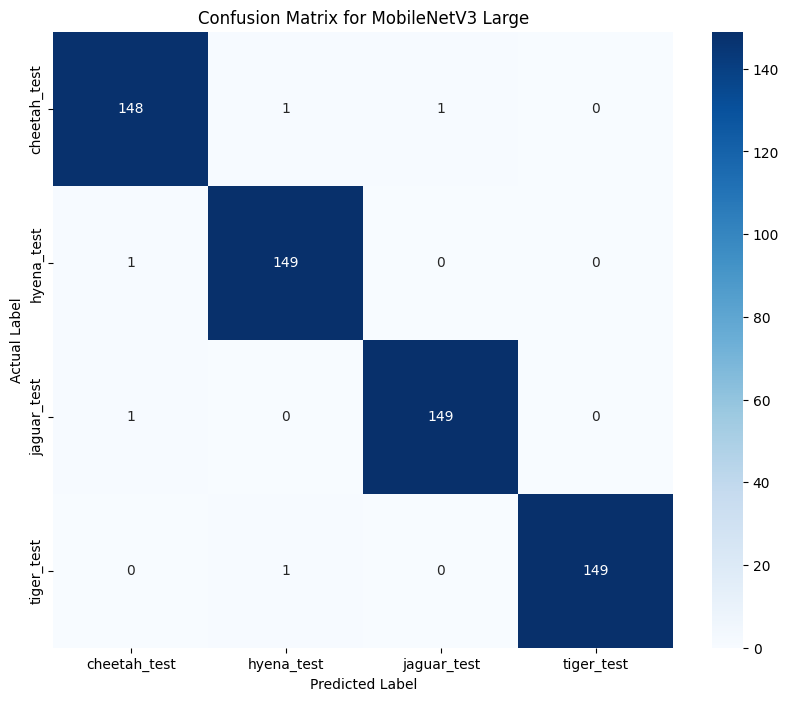

Classification Report for MobileNetV3 Large
              precision    recall  f1-score   support

cheetah_test       0.99      0.99      0.99       150
  hyena_test       0.99      0.99      0.99       150
 jaguar_test       0.99      0.99      0.99       150
  tiger_test       1.00      0.99      1.00       150

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



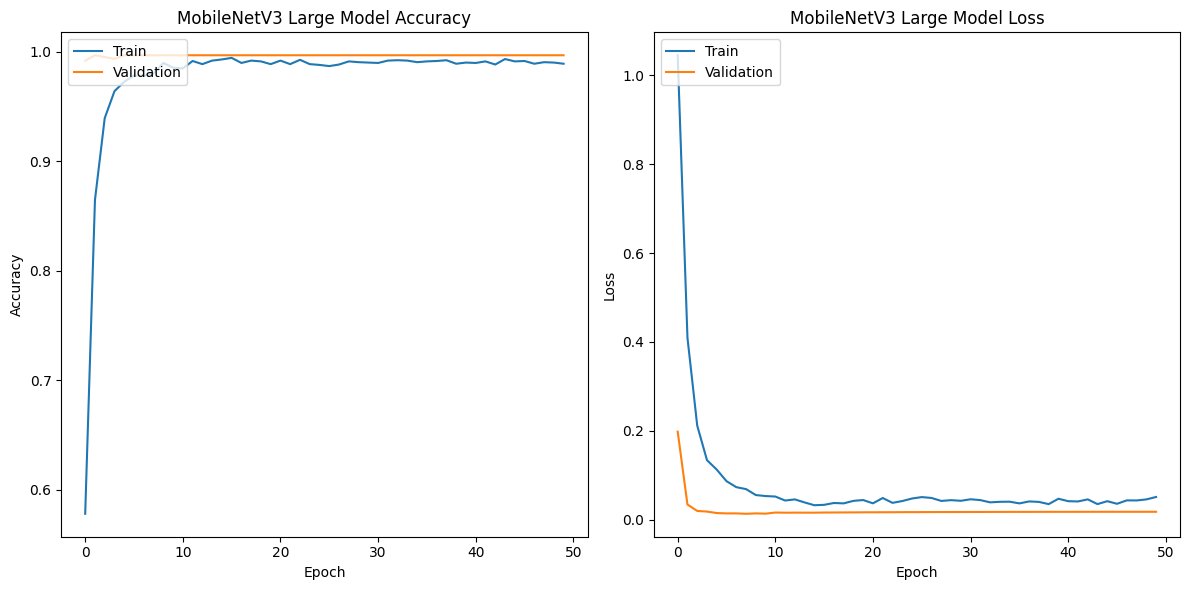

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32  # Increased batch size for more stable gradients

# Define paths
base_dir = r'D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# Data generators with stronger augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,  # Increased rotation
    width_shift_range=0.2,  # Increased shift
    height_shift_range=0.2,  # Increased shift
    shear_range=0.2,  # Increased shear
    zoom_range=0.2,  # Increased zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Added brightness variation
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the MobileNetV3 Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers with more regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Reduced from 512 to 256
x = Dropout(0.5)(x)  # Increased dropout from 0.3 to 0.5
x = Dense(128, activation='relu')(x)  # Added another layer
x = Dropout(0.4)(x)  # Additional dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze most layers but unfreeze last few layers for fine-tuning
for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
    layer.trainable = False
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Compile the model with even lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks with adjusted parameters
checkpoint = ModelCheckpoint('best_mobilenetv3_large_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-8, verbose=1)  # More aggressive LR reduction

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, reduce_lr]
)
end_time = time.time()
training_time = end_time - start_time


# Load the best model
model = tf.keras.models.load_model('best_mobilenetv3_large_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training completed in: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for MobileNetV3 Large')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for MobileNetV3 Large')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNetV3 Large Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV3 Large Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()